---
# **Final Project** | 02807 Computational Tools for Data Science
---


# **Table of contents**
1. [How to read this notebook](#HowToRead)

# **How to read this notebook** <a name="HowToRead"></a>
---

- The whole code is executable. Nevertheless, certain sections may require a more extended period to execute than others. Consequently, we advise against running the entire script in one go, unless waiting is not a concern for you. Instead, we recommend executing one cell at a time. In instances where a cell requires a longer computation time, a warning will be displayed as follows: **<span style = "color:red"> Warning: This takes [X] minutes to run**. Please be guided accordingly.

**About the project:**
- This project encompasses the development of a recommendation system that includes an interactive program. The primary objective is to provide movie recommendations to a user based on a previously watched movie. The structure of this notebook follows the process through which a final set of movie recommendations is generated for a user, predicated on a movie they have previously watched. The overall design of this system is as follows:
1. Read the movie data.
2. The data from *step 1* is then filtered based on genre.
3. The data from *step 2* is then filtered based on *network communities*.
4. The data from *step 3* is then filtered based on *topic modeling*.
5. The data from *step 4* is then filtered based on *similar users*.
6. Finally 5 movies will be recommended for the user.

# **Importing libraries**
---

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from itertools import combinations
from collections import Counter
from zipfile import ZipFile
import os
import json
import requests
import re
import itertools
from pprint import pprint
import math
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from tqdm import tqdm
import gensim
from gensim import corpora
from wordcloud import WordCloud
import colorsys
from scipy.spatial import distance
import contextlib


# Networkx and community
import networkx as nx
from networkx.algorithms.community import girvan_newman
import community
import community.community_louvain as cl
from sklearn.cluster import SpectralClustering

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
pd.options.mode.chained_assignment = None  # default='warn'
with contextlib.redirect_stdout(None):
    nltk.download('wordnet', quiet=True)
    nltk.download('stopwords', quiet=True)
    
# Interactive system
import tkinter as tk
from tkinter import messagebox, Scrollbar, Listbox, StringVar

In [2]:
# Reusable variables
seed = 33
d_color = "#4152ec"
network_color_map = "turbo"

# **Data loading**
---

In [3]:
# used csv files, linking it with their source zip files
csv_to_zip_source = {
    "Netflix_Dataset_Movie.csv": "zip_sources/Netflix_Dataset_Movie.csv.zip",
    "Netflix_Dataset_Rating.csv": "zip_sources/Netflix_Dataset_Rating.csv.zip",
    "tmdb_5000_credits.csv": "zip_sources/tmdb.zip",
    "tmdb_5000_movies.csv": "zip_sources/tmdb.zip"
}

csv_file_names = list(csv_to_zip_source.keys())

# common data directory path
data_dir = "./data"

# if directory does not exist, create it
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

# check if all .csv can be found in data directory, if not we extract it from corresponding zip source
for csv_file_name in csv_file_names:
    if not os.path.exists(f"{data_dir}/{csv_file_name}"):
        # if it is not found
        zip_source_file_name = csv_to_zip_source[csv_file_name]
        print(f"❗'{csv_file_name}' does not exist in the '{data_dir}' directory, extracting it from zip file '{zip_source_file_name}'...")
        with ZipFile(zip_source_file_name, 'r') as zip:
            zip.extract(csv_file_name, path=data_dir)
            print(f"Done extracting {csv_file_name} from {zip_source_file_name}")
    else:
        # csv exists and found, let user know
        print(f"'{data_dir}/{csv_file_name}' exists ✅")
    print("---")

'./data/Netflix_Dataset_Movie.csv' exists ✅
---
'./data/Netflix_Dataset_Rating.csv' exists ✅
---
'./data/tmdb_5000_credits.csv' exists ✅
---
'./data/tmdb_5000_movies.csv' exists ✅
---


In [4]:
movies = pd.read_csv(f"{data_dir}/Netflix_Dataset_Movie.csv")
ratings = pd.read_csv(f"{data_dir}/Netflix_Dataset_Rating.csv")
credits = pd.read_csv(f"{data_dir}/tmdb_5000_credits.csv")
df_tmdb = pd.read_csv(f"{data_dir}/tmdb_5000_movies.csv")

In [5]:
#changed
#df_tmdb = tmdb_movies[tmdb_movies.year >= 2005] #subset of tmdb data set
movies_subset = movies[(movies.Name.isin(df_tmdb.title)) & (movies.Movie_ID.isin(ratings.Movie_ID))] #only movies that is in tmdb dataset and is rated

In [6]:
#remove movies, where there are either/or not genres, keywords or tagline
df_tmdb = df_tmdb[df_tmdb.genres != '[]']
df_tmdb = df_tmdb[df_tmdb.keywords != '[]']
df_tmdb = df_tmdb[df_tmdb.tagline.notnull()].reset_index()

In [7]:
#remove movies not in df_tmdb(after some were removed)
df_movies = movies_subset[movies_subset.Name.isin(df_tmdb.title)]
df_ratings = ratings[ratings.Movie_ID.isin(df_movies.Movie_ID)]

In [8]:
new_movies = df_tmdb[~df_tmdb.title.isin(df_movies.Name)]
df_tmdb = pd.concat([new_movies.sample(n=1620, random_state=1), df_tmdb[df_tmdb.title.isin(df_movies.Name)]]).reset_index()
df_credits = credits[credits.title.isin(df_tmdb.title)]

In [9]:
print("Number of unique movie ID's:", len(df_movies.Movie_ID.unique()))
print("Number of movies:", len(df_movies.Name.unique()))

Number of unique movie ID's: 385
Number of movies: 380


Some movies are in the data with different ID. However, this has not been changed.

In [10]:
#convert from string to list
df_tmdb['genres'] = df_tmdb['genres'].apply(json.loads)
df_tmdb['keywords'] = df_tmdb['keywords'].apply(json.loads)

In [11]:
def convertJSON(df, column): #column as string
    columnDict = {}
    for i in range(0,len(df)): #loop through index
        columnList = []
        for j in range(0, len(df[column][i])): #loop through column for that row
            columnList.append(df[column][i][j]['name'])
        columnDict[i] = ', '.join(columnList)
        
    return columnDict

In [12]:
#convert from json 
genreDict = convertJSON(df_tmdb, 'genres')
keywordsDict = convertJSON(df_tmdb, 'keywords')

df_tmdb['genres'] = genreDict.values()
df_tmdb['keywords'] = keywordsDict.values()

# **1. Find preferred genre**
---

In [13]:
def filterByGenre(movieTitle, df): #find movies with at least one of the same genres as the movie just seen
    genres = df[df.title == movieTitle].genres.str.replace(' ', '|').iloc[0] ##replace , by |. This is the genres to look for in 
    genreMovies = df[df.genres.str.contains(genres)] #find movies with at least one of the genres
    
    return genreMovies

# **2. Movie network**
---
The network analysis investigates the relationship between movies through their cast. The network will consists of nodes which will represent movies. A pair of movies will have an edge between them if they have at least one common actor of their top five actors.

- **Nodes**: Movies
- **Edges**: Two movies are connected if they have a common actor in their top 5 staring actors.

## **Network**

In [14]:
G_movies = nx.Graph()

# Iterate over each row in the credits dataframe
for index, row in df_credits.iterrows():
    cast = json.loads(row['cast']) # Parse the cast column (=JSON string)
    
    # Get names of the first 5 actors
    actors = [actor['name'] for actor in cast[:5]]
    G_movies.add_node(row['title'], actors=actors)

# Iterate over all pairs of movies
for movie1, movie2 in combinations(G_movies.nodes, 2):
    # Actors for each movie
    actors1 = G_movies.nodes[movie1]['actors']
    actors2 = G_movies.nodes[movie2]['actors']
    common_actors = len(set(actors1) & set(actors2)) # Number of common actors
    
    # If they have at least 1 common actors, add an edge between them
    if common_actors >= 1:
        G_movies.add_edge(movie1, movie2)


### **Get largest connected component**

In [15]:
# Largest connected component
largest_cc = max(nx.connected_components(G_movies), key=len)
G_movies_lcc = G_movies.subgraph(largest_cc)

### **Plot of network (largest connected compoennt)**

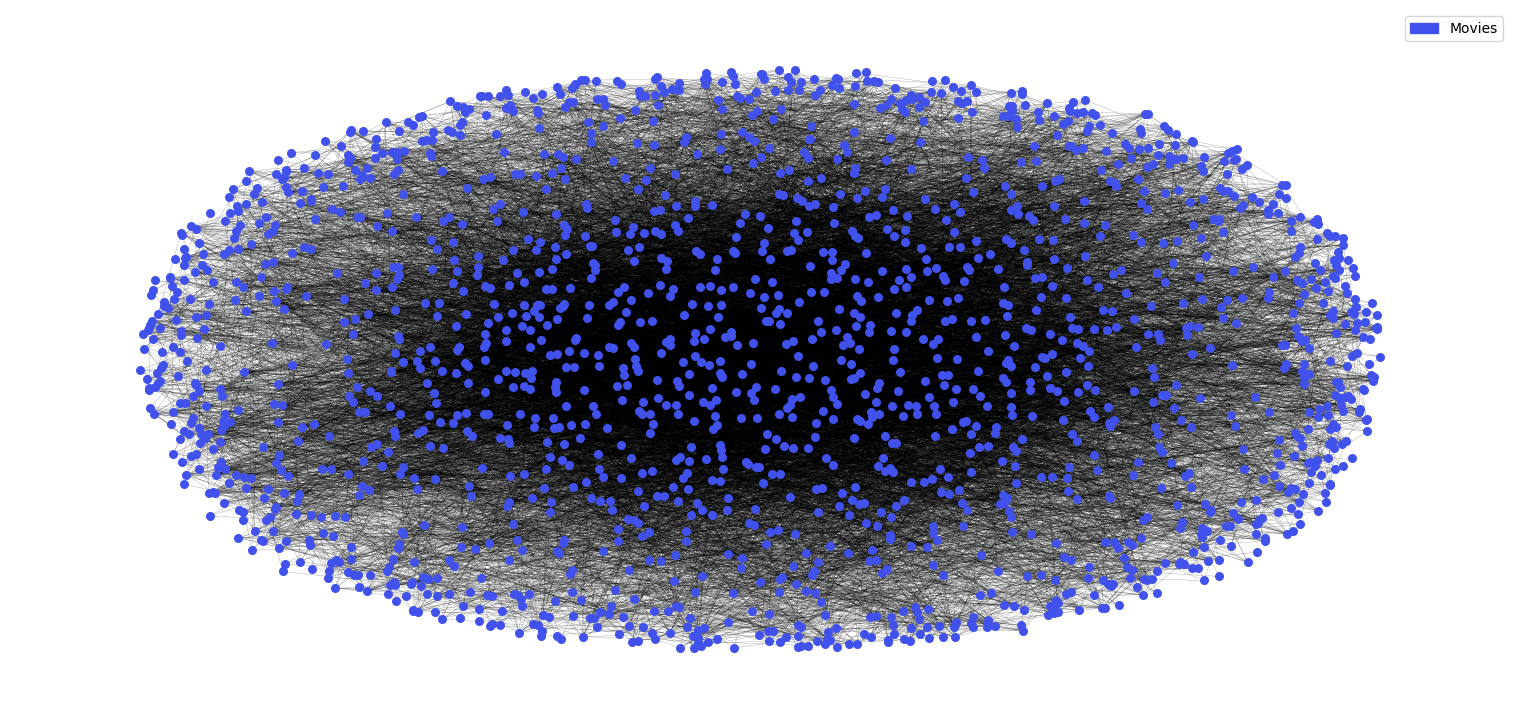

In [16]:
# Layout
plt.figure(figsize=(15, 7))
pos = nx.spring_layout(G_movies_lcc, k=0.7)

# Draw network
nx.draw(G_movies_lcc, pos, node_color=d_color, edge_color='black', with_labels=False, node_size=30, width=0.1)

# Legend
movies_patch = mpatches.Patch(color=d_color, label='Movies')
plt.legend(handles=[movies_patch])
plt.show()

### **Nodes and edges**

In [17]:
# For the whole network
n_nodes = len(G_movies.nodes())
n_edges = len(G_movies.edges())
print("Number of nodes:", n_nodes)
print("Number of edges:", n_edges)

Number of nodes: 1999
Number of edges: 18393


In [18]:
# For the network consisting only of the largest connected component
n_nodes = len(G_movies_lcc.nodes())
n_edges = len(G_movies_lcc.edges())
print("Number of nodes:", n_nodes)
print("Number of edges:", n_edges)

Number of nodes: 1857
Number of edges: 18385


## **Communities**

In [19]:
# Girvan–Newman algorithm
# Approx 4:40 min
nx_communities = nx.algorithms.centrality.edge_betweenness_centrality(G_movies_lcc)
nx_girvan_newman = nx.algorithms.community.centrality.girvan_newman(G_movies_lcc)
nx_best_community = tuple(sorted(c) for c in next(nx_girvan_newman))
num_communities = len(nx_best_community)
nx_modularity_G = nx.algorithms.community.quality.modularity(G_movies_lcc, nx_best_community)

print("Girvan–Newman:")
print("\t- Number of communities found by Girvan-Newman:", num_communities)
print("\t- Modularity:", round(nx_modularity_G,3))

Girvan–Newman:
	- Number of communities found by Girvan-Newman: 2
	- Modularity: 0.003


In [20]:
# Louvain algorithm
communities_Louvain = cl.best_partition(G_movies_lcc, random_state=seed)
n_communities_Louvain = len(np.unique(list(communities_Louvain.values())))
modularity_Louvain = community.modularity(communities_Louvain, G_movies_lcc)

print("Louvain:")
print("\t- Number of communities found by Louvain:", n_communities_Louvain)
print("\t- Modularity:", round(modularity_Louvain,3))

Louvain:
	- Number of communities found by Louvain: 21
	- Modularity: 0.409


In [21]:
# Spectral clustering - Finding the best number of clusters
# Approx 8 min 
np.random.seed(seed)

adj_mat = nx.to_numpy_array(G_movies_lcc)
nodes = list(G_movies_lcc.nodes())

best_modularity = -np.inf
best_n_clusters = None
best_communities = None

# Try different numbers of clusters
for n_clusters in range(2, 100):
    sc = SpectralClustering(n_clusters, affinity='precomputed', n_init=100)
    sc.fit(adj_mat)

    # Convert labels array to list of sets format
    communities = [set(nodes[i] for i in np.where(sc.labels_ == j)[0]) for j in range(n_clusters)]
    modularity = nx.algorithms.community.quality.modularity(G_movies_lcc, communities)

    # Update
    if modularity > best_modularity:
        best_modularity = modularity
        best_n_clusters = n_clusters
        best_communities = communities

print("Best modularity is", best_modularity, "found with", best_n_clusters, "clusters.")
# Approx 3:33 min to run

c:\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Best modularity is 0.3489888641023453 found with 80 clusters.


C:\Users\mydun\AppData\Local\Temp\ipykernel_24220\3533614995.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(network_color_map, n_communities_Louvain + 2)


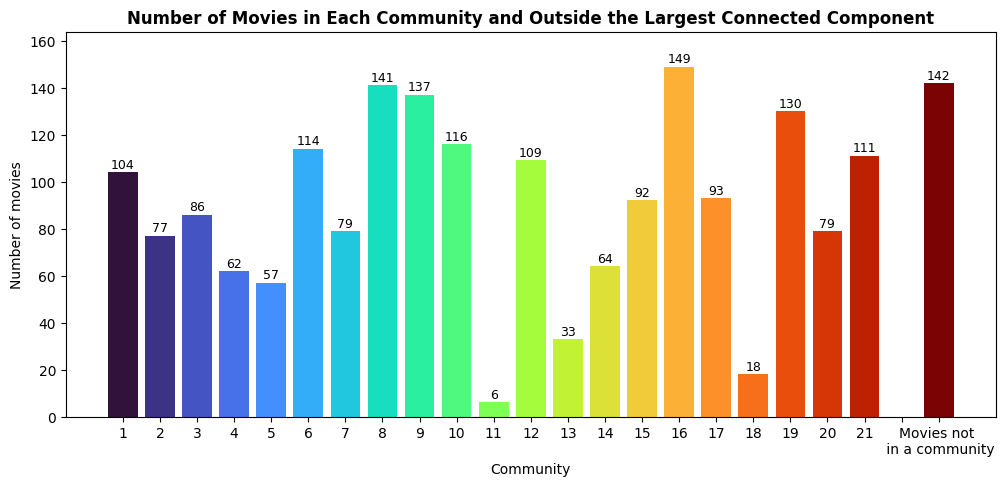

In [22]:
# Number of movies in each community
communities_Louvain_list = [set() for _ in range(n_communities_Louvain)]
for node, community_id in communities_Louvain.items():
    communities_Louvain_list[community_id].add(node)

num_movies = [len(community) for community in communities_Louvain_list]

# Calculating nodes that is not in the largest connected component
all_nodes = set(G_movies.nodes())
lcc_nodes = set(G_movies_lcc.nodes())
non_lcc_nodes = all_nodes - lcc_nodes
num_non_lcc_movies = len(non_lcc_nodes)
num_movies.append(0) # Add an empty bar before the last bar (Just to seperate the last bar)
num_movies.append(num_non_lcc_movies) # Add the number to num_movies

# Colors
cmap = plt.cm.get_cmap(network_color_map, n_communities_Louvain + 2)

# Histogram
plt.figure(figsize=(12, 5))
bars = plt.bar(range(1, n_communities_Louvain + 3), num_movies, color=cmap(range(n_communities_Louvain + 2)))

# Create a list of labels for the x-axis
xtick_labels = [str(i) for i in range(1, n_communities_Louvain + 1)] + ["", "Movies not \n in a community"]
plt.xticks(range(1, n_communities_Louvain + 3), xtick_labels)

plt.ylim(0, max(num_movies) + (max(num_movies)/10))
plt.xlabel("Community")
plt.ylabel("Number of movies")
plt.title("Number of Movies in Each Community and Outside the Largest Connected Component", fontweight="bold")

# Add the precise number of movies above each bar
for i, bar in enumerate(bars):
    bar_height = bar.get_height()
    if bar_height != 0:  # Skip the empty bar
        plt.text(bar.get_x() + bar.get_width()/2, bar_height + 0.5, bar_height, ha="center", va="bottom", fontsize=9)

plt.show()
# Explain the last bar

C:\Users\mydun\AppData\Local\Temp\ipykernel_24220\184690834.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_new = plt.cm.get_cmap(network_color_map, len(communities_Louvain_list) + 2)
c:\Python310\lib\site-packages\networkx\drawing\nx_pylab.py:304: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


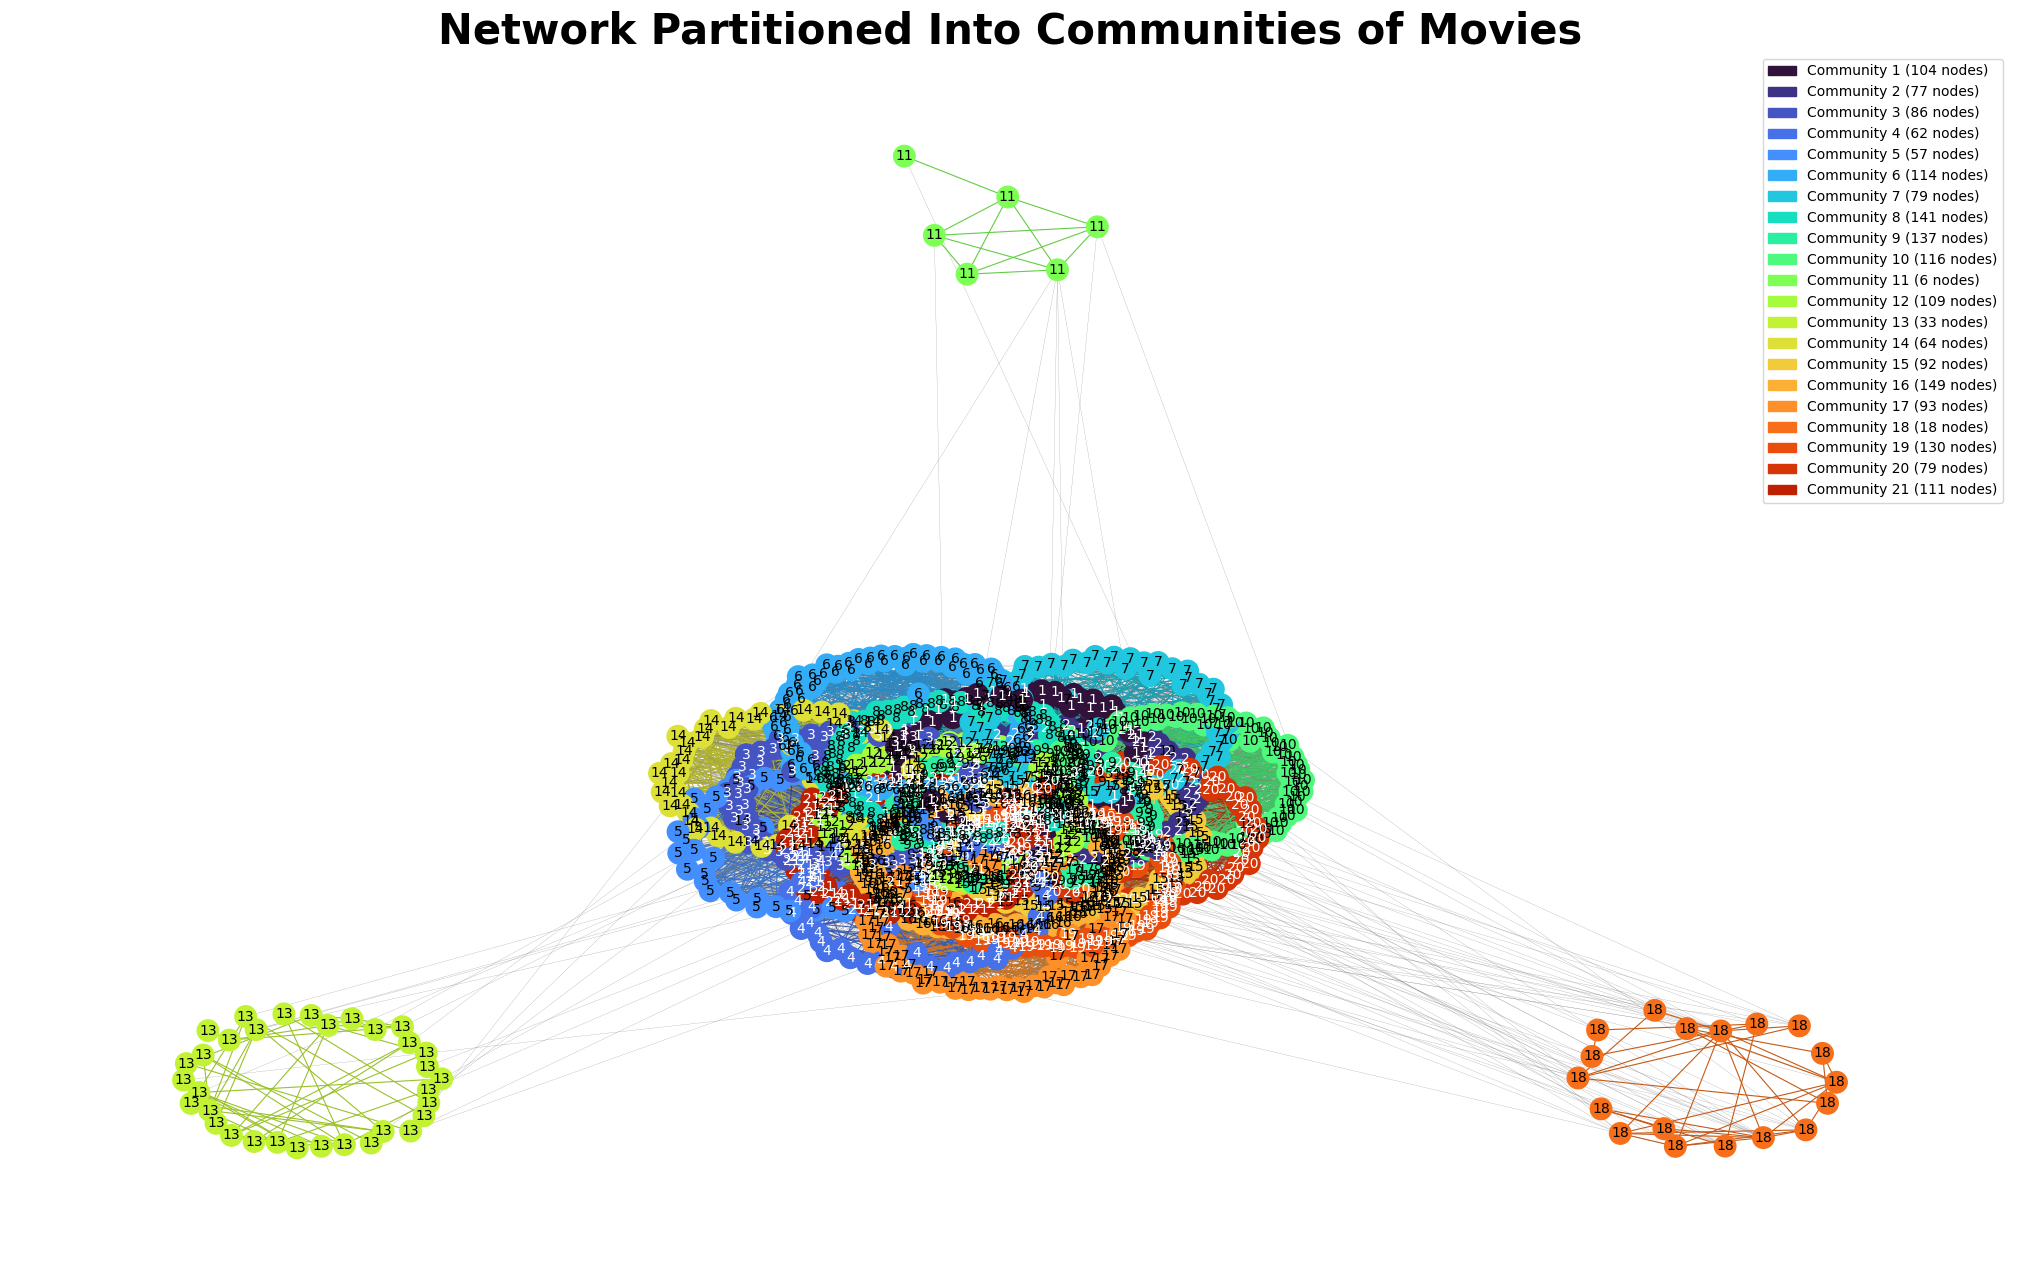

In [23]:
cmap_new = plt.cm.get_cmap(network_color_map, len(communities_Louvain_list) + 2)
community_to_color = {i: cmap_new(i) for i in range(len(communities_Louvain_list) + 2)}
color_map = {node: community_to_color[communities_Louvain[node]] for node in G_movies_lcc.nodes if communities_Louvain[node] in community_to_color}


# To determine the brightness of a node to see if its label should be black or white
def brightness(color):
    # Based on https://stackoverflow.com/questions/596216/formula-to-determine-perceived-brightness-of-rgb-color
    rgb = mcolors.colorConverter.to_rgb(color)
    return 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]

# To darken colors of the edges between two nodes from the same community
def darken_color(color, factor=0.8):
    rgb = mcolors.colorConverter.to_rgb(color)
    hsv = colorsys.rgb_to_hsv(*rgb)
    hsv_darker = hsv[0], hsv[1], hsv[2] * factor
    rgb_darker = colorsys.hsv_to_rgb(*hsv_darker)
    return rgb_darker

def community_layout(g, partition, seed=None):
    pos_communities = position_communities(g, partition, seed=seed, scale=25)
    pos_nodes = position_nodes(g, partition, seed=seed, scale=3)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def position_communities(g, partition, seed=None, **kwargs):
    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, seed=seed, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def find_between_community_edges(g, partition):
    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def position_nodes(g, partition, seed=None, **kwargs):
    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for _, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        # pos_subgraph = nx.spring_layout(subgraph, seed=seed, **kwargs)
        # pos_subgraph = nx.kamada_kawai_layout(subgraph, **kwargs)
        pos_subgraph = nx.spring_layout(subgraph, seed=seed, k=3, **kwargs)
        pos.update(pos_subgraph)

    return pos

# Node labels 
labels = {node: communities_Louvain[node] + 1 for node in G_movies_lcc.nodes}
label_colors = {node: "white" if brightness(color_map.get(node, "grey")) < 0.5 else "black" for node in G_movies_lcc.nodes}
pos = community_layout(G_movies_lcc, communities_Louvain, seed=seed)


# Legend
patches = [mpatches.Patch(color=community_to_color[i], label=f"Community {i+1} ({len(communities_Louvain_list[i])} nodes)") for i in range(len(communities_Louvain_list))]

# Edges
edge_colors = [darken_color(color_map.get(n1, "grey")) if communities_Louvain[n1] == communities_Louvain[n2] else "grey" for n1, n2 in G_movies_lcc.edges()]
edge_widths = [0.8 if communities_Louvain[n1] == communities_Louvain[n2] else 0.15 for n1, n2 in G_movies_lcc.edges()]


# Plot
plt.figure(figsize=(20, 12))
nx.draw(G_movies_lcc, pos, node_color=[color_map.get(node, "grey") for node in G_movies_lcc.nodes], edge_color=edge_colors, width=edge_widths, with_labels=False, node_size=240)

for node, (x, y) in pos.items():
    plt.text(x, y, labels[node], fontsize=10, color=label_colors[node], ha="center", va="center")

plt.legend(handles=patches)
plt.title("Network Partitioned Into Communities of Movies", fontsize=30, fontweight="bold")
plt.show()

## **Degrees**
- A high degree count for a movie means that the movie shares a significant number of actors with many other movies. This means that many of the actors in the movie have also acted in a large number of other movies in the network. This could indicate that the movie has a well-known or versatile cast.

In [24]:
# Both old and new users
degrees = G_movies.degree()
top_10_movies_degree = sorted(degrees, key=lambda x: x[1], reverse=True)[:10]
for movie, degree in top_10_movies_degree:
    print(f'{movie}: {degree}')

Pulp Fiction: 69
The Other Guys: 66
The Life Aquatic with Steve Zissou: 65
The Expendables 3: 63
Ocean's Eleven: 62
Shark Tale: 62
The Monuments Men: 62
Little Fockers: 60
The Expendables 2: 60
What Just Happened: 60


## **Betweenness centrality**
- Betweenness centrality is a measure of a node’s centrality in a network. It is equal to the number of shortest paths from all vertices to all others that pass through that node. A higher betweenness centrality generally means that a node is more central in the network.
- Maybe use for new users (no movies seen yet). The movies with high betweenness centrality would be good for new users as the movies are connected to many other movies in the network through shared actors. 

In [25]:
# Use for new users maybe
centrality = nx.betweenness_centrality(G_movies)
top_10_movies_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for movie, centrality in top_10_movies_centrality:
    print(f'{movie}: {centrality}')

Quills: 0.008771952576716731
The Expendables 3: 0.006945282997035505
Pulp Fiction: 0.005935224856017994
A Time to Kill: 0.005689238165208346
The Life Aquatic with Steve Zissou: 0.005474015767178647
The Prince of Egypt: 0.005328671195526448
The Other Guys: 0.005222726741142747
The Omen: 0.0051422346909179096
The Expendables 2: 0.005083058593406976
A Streetcar Named Desire: 0.004737245513351599


## **Recommend movies based on communites**
- Sort these movies based on number of common actors

In [26]:
# Should have seen at least one movie. Recommend based on latest seen movie.
def top_10_movies_common_actors(movie_title, G_movies):
    given_movie_actors = set(G_movies.nodes[movie_title]['actors'])

    # Number of common actors for each movie
    common_actors = {movie: len(given_movie_actors & set(G_movies.nodes[movie]['actors'])) for movie in G_movies.nodes if movie != movie_title}
    common_actors = {movie: actors for movie, actors in common_actors.items() if actors > 0}
    if not common_actors:
        print(f'No movies found with common actors to "{movie_title}".')
        return []
    sorted_movies = sorted(common_actors.items(), key=lambda x: x[1], reverse=True)
    top_movies = sorted_movies

    return top_movies

In [27]:
def print_movie_community(movie_title, communities):
    for i, community in enumerate(communities, start=1):
        if movie_title in community:
            print(f'"{movie_title}" is in Community {i}. These are the top 10 recommended movies with common actors:')
            sorted_movies = top_10_movies_common_actors(movie_title, G_movies)
            sorted_movies = [movie for movie in sorted_movies if movie[0] in community]
            for movie, common_actors in sorted_movies:
                print(f'\t- {movie}: {common_actors}')
            if len(sorted_movies) < 10:
                print(f'\nNote: There are only {len(sorted_movies)} movies with common actors to "{movie_title}".')
            break
    else:
        print(f'"{movie_title}" is not found in any community.')


In [28]:
print_movie_community("About Schmidt", communities_Louvain_list)

"About Schmidt" is in Community 19. These are the top 10 recommended movies with common actors:
	- Titanic: 1
	- How Do You Know: 1
	- Something's Gotta Give: 1
	- The Day the Earth Stood Still: 1
	- Wolf: 1
	- Dragonfly: 1
	- As Good as It Gets: 1
	- Reds: 1
	- Little Black Book: 1
	- The Boss: 1
	- The Shining: 1
	- Kansas City: 1
	- The Family Stone: 1
	- Young Guns: 1
	- The Postman Always Rings Twice: 1
	- Insidious: Chapter 3: 1


In [29]:
def get_movie_community_df(movie_title, df):
    # Find community of the given movie
    for community in communities_Louvain_list:
        if movie_title in community:
            df_tmdb_community = df[df['title'].isin(community)] # Filter dataframe so it only includes the movies in the community of the input movie           
            return df_tmdb_community

    print(f'"{movie_title}" is not found in any community.')
    return pd.DataFrame()

df_tmdb_new = get_movie_community_df("About Schmidt", df_tmdb)
# TODO: If movie is not in a community then return df. I.e. skip network part

---
# **Topic Modeling**
---


## **Text preprocessing**
Before performing Topic Modeling, we need to preprocess the data. For the preprocessing, the function `preProcess`, is created. This function make text to lowercase, remove stop words, remove punctuation and lemmatize the text. Stopwords will be removed before removing punctuation. 

In [30]:
def removeStopWords(string):
    new_string = []
    stopWords = stopwords.words('english')
    
    for s in string.split():
        if s not in stopWords:
            new_string.append(s)
    final_string = ' '.join(new_string)
    
    return final_string

In [31]:
def remove(string, regex):
    result = re.sub(regex, '', string)
    
    return result

In [32]:
def removePunctuation(string): #remove: . , ! ? ' ’ : " ( ) $ - and numbers
    reg = [r'\.', r'\,', r'\?', r'\'', r'’', r'\"', r':', r':', r'\(', r'\)', r'\$', r'-', r'\d'] 

    for r in reg:
        string = remove(string, r)
        
    return string


#remove stopwords and split

In [33]:
def lemmatize(string):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    
    for w in string.split():
        lemmatized_words.append(lemmatizer.lemmatize(w))
    lemmatized_sentence = ' '.join(lemmatized_words)
    
    return lemmatized_sentence

In [34]:
def preProcess(df, column): #function for all preprocess
    lower = df[column].str.lower() #lowercase
    removeStopW = lower.apply(lambda x: removeStopWords(x)) #remove stop words
    removePunct = removeStopW.apply(lambda x: removePunctuation(x)) #remove punctuation
    df[column] = removePunct.apply(lambda x: lemmatize(x)) #lemmatize
 
    return df[column]

In [35]:
def createDocs(df, column): #create documents for movies
    text_list = ','.join(df[column]).split(',') #get all text into a list. Each document/movie is splitted by comma 
    text = [d.split() for d in text_list] #get a lis of list, where each list is a document/movie. Each word is as individually string. get each string into array.
    
    return text

In [36]:
def getDictCorpus(text): #create dictionary and corpus
    #create dictionary
    dictionary = corpora.Dictionary(text) #create dictionary
    
    #create corpus
    corpus = [dictionary.doc2bow(t) for t in text]
    
    return dictionary, corpus

In [37]:
#preprocess
movie_text = pd.DataFrame()
movie_text['title'] = df_tmdb['title']
movie_text['overview'] = preProcess(df_tmdb, 'overview')
movie_text['tagline'] = preProcess(df_tmdb, 'tagline')
movie_text['genres'] = preProcess(df_tmdb, 'genres')
movie_text['keywords'] = preProcess(df_tmdb, 'keywords')

ind = movie_text[movie_text.tagline != ''].index #index of movie without tagline
movie_text = movie_text.iloc[ind].reset_index()

#create text
overviewText = createDocs(movie_text, 'overview')
taglineText = createDocs(movie_text, 'tagline')
genresText = createDocs(movie_text, 'genres')
keywordsText = createDocs(movie_text, 'keywords')

#create dictionary and corpus
overviewDict, overviewCorpus = getDictCorpus(overviewText)
taglineDict, taglineCorpus = getDictCorpus(taglineText)
genresDict, genresCorpus = getDictCorpus(genresText)
keywordsDict, keywordsCorpus = getDictCorpus(keywordsText)

## **TF-IDF**
After the preprocessing were performed, we started looking at TF-IDF. This shows the words that is most important/tells most about the text of the movie. This means, that it will not show the words that are often in a lot of the text about movies. There are several kinds of TF-IDF but the one performed here is the one taught in class.

In [38]:
def tf_idf(corpus, dictionary, documents):
    N = len(corpus) #number of documents
    f = np.zeros((len(documents), len(dictionary)))#matrix in size: number of documents x number of unique words in all documents
    tf = np.zeros((len(documents), len(dictionary)))#matrix in size: number of documents x number of unique words in all documents
    n_t = np.zeros(len(dictionary)) #array for counting number of documents word t appears in
    
    #for d in documents: #loop through all documents
    for d in range(0,len(documents)):
        for key in dictionary.keys(): #loop through all words
            word = dictionary[key]
            wordCount = documents[d].count(word) #count occurence of word in each document
            f[d, key] = wordCount
            
            if wordCount >= 1: #if word is in document, add 1 to document count
                n_t[key] += 1 
            
        tf[d,:] = f[d,:]/max(f[d,:]) 
    
    idf = np.log2((N/n_t))
    TF_IDF = tf * idf
   
    return TF_IDF

In [39]:
TF_IDF_overview = tf_idf(overviewCorpus, overviewDict, overviewText)
TF_IDF_tagline = tf_idf(taglineCorpus, taglineDict, taglineText)
TF_IDF_genres = tf_idf(genresCorpus, genresDict, genresText)
TF_IDF_keywords = tf_idf(keywordsCorpus, keywordsDict, keywordsText)

## **Wordcloud**
After performing TF-IDF, we take a look at woudclouds for overview, tagline, genres and keywords. The wordclouds are shown with and without TF-IDF, and are shown for all data(after removing movies with missing data for those four text attributes). It seems that for overview, tagline and genre the wordclouds with and without TF-IDF seems quite similar. Since TF-IDF is great for finding topics, we chose to use the 10 most important words in a text(according to TF-IDF) for the topic modeling. We hope this will give us the topics that tells most about the movies. 

In [40]:
def wordCloud(df, column): #create wordcloud for plotting
    text = ' '.join(df[column])
    
    wordcloud = WordCloud().generate(text)
    return wordcloud

In [41]:
wordcloud_overview = wordCloud(movie_text, 'overview')
wordcloud_tagline = wordCloud(movie_text, 'tagline')
wordcloud_genre_text = wordCloud(movie_text, 'genres')
wordcloud_keywords_text = wordCloud(movie_text, 'keywords')

c:\Python310\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Python310\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Python310\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Python310\lib\site-packages\wordcloud

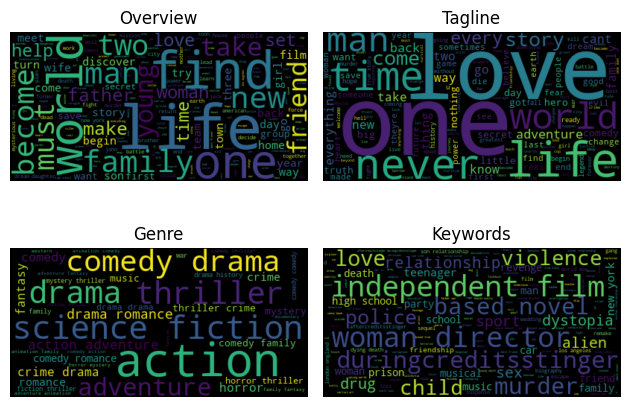

In [42]:
#plot wordcloud for preprocessed text(wihtout TF-IDF)
plt.subplots(nrows=2, ncols=2)
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_overview, interpolation = 'bilinear')
plt.axis("off")
plt.title("Overview")

plt.subplot(2, 2, 2)
plt.imshow(wordcloud_tagline, interpolation = 'bilinear')
plt.axis("off")
plt.title("Tagline")

plt.subplot(2, 2, 3)
plt.imshow(wordcloud_genre_text, interpolation = 'bilinear')
plt.axis("off")
plt.title("Genre")

plt.subplot(2, 2, 4)
plt.imshow(wordcloud_keywords_text, interpolation = 'bilinear')
plt.axis("off")
plt.title("Keywords")


plt.tight_layout()
plt.show()

In [43]:
def frequency(TF_IDF_array, dictionary):
    frequency_dict = {}
    for i in range(0, len(dictionary)):
        frequency_dict[dictionary[i]] = np.sum(TF_IDF_array[:,i])
    return frequency_dict

In [44]:
#create dict with frequency of TF-IDF
overviewFrequency = frequency(TF_IDF_overview, overviewDict)
taglineFrequency = frequency(TF_IDF_tagline, taglineDict)
genreFrequency = frequency(TF_IDF_genres, genresDict)
keywordsFrequency = frequency(TF_IDF_keywords, keywordsDict)

In [45]:
#create wordclouds for TF-IDF
overviewWordcloud = WordCloud().generate_from_frequencies(frequencies = overviewFrequency)
taglineWordcloud = WordCloud().generate_from_frequencies(frequencies = taglineFrequency)
genreWordcloud = WordCloud().generate_from_frequencies(frequencies = genreFrequency)
keywordsWordcloud = WordCloud().generate_from_frequencies(frequencies = keywordsFrequency)

c:\Python310\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Python310\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Python310\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Python310\lib\site-packages\wordcloud

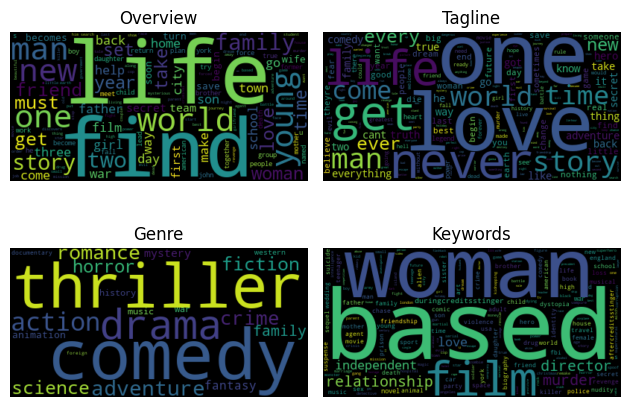

In [46]:
#plot wordcloud for preprocessed text(with frequency as weight based on TF-IDF)
plt.subplots(nrows=2, ncols=2)
plt.subplot(2, 2, 1)
plt.imshow(overviewWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Overview")

plt.subplot(2, 2, 2)
plt.imshow(taglineWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Tagline")

plt.subplot(2, 2, 3)
plt.imshow(genreWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Genre")

plt.subplot(2, 2, 4)
plt.imshow(keywordsWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Keywords")

plt.tight_layout()
plt.show()

In [47]:
def getImportantWords(tf_idf, corpus, dictionary): #find 10 most important words based on TF-IDF
    important_words = []
    for d in range(0,len(corpus)):
        index_largest = tf_idf[d,:].argsort()[-10:]
        important_words.append([dictionary[i] for i in index_largest])
        
    return important_words

In [48]:
#get 10 most important words for each movie
importantWords_overview = getImportantWords(TF_IDF_overview, overviewCorpus, overviewDict)
importantWords_tagline = getImportantWords(TF_IDF_tagline, taglineCorpus, taglineDict)
importantWords_genre = getImportantWords(TF_IDF_genres, genresCorpus, genresDict)
importantWords_keywords = getImportantWords(TF_IDF_keywords, keywordsCorpus, keywordsDict)

In [49]:
#create corpus from important words
#overviewCorpus_importantW =  [overviewDict.doc2bow(text) for text in importantWords_overview]
#taglineCorpus_importantW =  [taglineDict.doc2bow(text) for text in importantWords_tagline]
#genreCorpus_importantW =  [genresDict.doc2bow(text) for text in importantWords_genre]
#keywordsCorpus_importantW =  [keywordsDict.doc2bow(text) for text in importantWords_keywords]

## **LDA**
Now for the actual topic modeling. We tried to do topic modeling with all words from the preprocessing and with the 10 most important words based on TF-IDF. As already mentioned we chose to use word from TF-IDF to find topics. Furthermore, we tried to do topic modeling with genres, tagline, overview and keywords, but ended up using only overview and keywords. The reason for not performing topic modeling on genre is that a genres is already topics movies are grouped into. Therefore we chose to use the genres in the beginning of the recommender system instead. 
The reason for not performing topic modeling on the tagline is that it didn't really explaing much about the movies, so we didn't think it was a good attribute to base a recommendation on. 


The topic modeling is performed using Latent Dirichlet Allocation(LDA). The implementation is performed with inspiration from [this](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) article. To perform LDA, we need to know the number of topics. There are different ways to investigate this, but here we have chosen to try different number of topics, and check how the topics look, and how it looks when plotted. Besides that, we don't want only a few movies in the same topic, because we want to find movies within the same topics, as a movie the user liked. But before recommending movies, we want to find similar users, and base our final recommendation on which movies the similar users liked. Therefore, we need a certain amount of movies in each topic, otherwise we won't have any movies left to recommend. The topic modeling is performed on overview if there are at least 40 movies left to recommend. We want there to be 20 movies in each topic on average, so this is how the number of topics are chosen for topic modeling on overview. 
After that, we do topic modeling on keywords if there are at least 20  movies left. We want there to 10 movies in each topic on average, so this is how the number of topics are chosen for topic modeling on keywords. 

In [50]:
def LDA(n_topics, corpus, dictionary): #create function for LDA
    lda = gensim.models.LdaMulticore(corpus = corpus,
                                       id2word=dictionary,
                                       num_topics=n_topics, 
                                     random_state= 5)
    return lda

In [51]:
def LDA_plot(path, lda_model, corpus, dictionary, n_topics): #function for plotting topics
    #Visualize topics
    pyLDAvis.enable_notebook()
    LDAvis_data_filepath = os.path.join(path + str(n_topics))
    
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
            
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
        
    pyLDAvis.save_html(LDAvis_prepared, path+ str(n_topics) +'.html')
    
    return LDAvis_prepared 

In [52]:
def assignTopic(lda, text, corpus): #assign topic with highest score
    assignedTopic = []
    for t in lda[corpus]: #loop through topics
        topic = []
        score = []
        for i in t:
            topic.append(i[0])
            score.append(i[1])
        assignedTopic.append(topic[np.argmax(score)]) #assign topic with highest score
    return assignedTopic

In [53]:
def TopicModeling_preprocessing(df, column):
    #create preProcess df
    df[column] = preProcess(df, column)
    
    #create dictionary, corpus and text for overview from preprocessed data
    colText = createDocs(df, column)
    colDict, colCorpus = getDictCorpus(colText)
    
    #TF-IDF
    TF_IDF = tf_idf(colCorpus, colDict, colText)
   
    #10 most important words - get text
    text = getImportantWords(TF_IDF, colCorpus, colDict)
    #dict and corpus for 10 most important words
    dictionary, corpus = getDictCorpus(text)
    
    return dictionary, corpus, text

In [54]:
#the reason we do topic modeling for overview first, is because we believe that tells more about the movie than keywords

In [55]:
#find movies where both topics are the same.
#If there are none, find result for only overview

In [56]:
def TopicModeling(df, movieTitle):
    if len(df) >= 15: #do topic modeling
        # get dictionary, corpus and text, 10 most important words
        overviewDict, overviewCorpus, overviewText = TopicModeling_preprocessing(df, 'overview')
        keywordsDict, keywordsCorpus, keywordsText = TopicModeling_preprocessing(df, 'keywords')
        n_topics = int(np.floor(len(df)/8)) #number of topics is assigned such that there on average is 6 movies per topic for overview
        
        #create LDA
        overviewLDA = LDA(n_topics, overviewCorpus, overviewDict)
        keywordsLDA = LDA(n_topics, keywordsCorpus, keywordsDict)
    
        #get columns for topics
        overviewTopic = assignTopic(overviewLDA, overviewText, overviewCorpus)
        keywordsTopic = assignTopic(keywordsLDA, keywordsText, keywordsCorpus) 
        #add overview topic to df
        df['overview_topic'] = overviewTopic 
        df['keywords_topic'] = keywordsTopic 
        
        #Topics for the seen movie
        movie_overviewTopic = df[df.title == movieTitle].overview_topic.iloc[0]
        movie_keywordsTopic = df[df.title == movieTitle].keywords_topic.iloc[0]
        
    
        #find movies where movies have at least one topic(overview or keywords) as the movieTitle
        TP_recommend = df[(df.overview_topic == movie_overviewTopic) | (df.keywords_topic == movie_keywordsTopic)]
            
    else:
        TP_recommend = df
    
    recommendedMovies = TP_recommend[TP_recommend.title != movieTitle] #remove seen movie
    
    return recommendedMovies

Here is shown the topics and plot for topic modeling for overview, based on TF-IDF, to show how it can.

In [57]:
dictionary, corpus, text = TopicModeling_preprocessing(movie_text, 'overview')
n_topics = 100
overviewLDA = LDA(n_topics, corpus, dictionary)

In [58]:
#show example with plot and print
# overviewLDA_plot = LDA_plot('results/ldavis_prepared_', overviewLDA, corpus, dictionary, n_topics) #create plot

---

# **Selecting similar users (under Book chapter 9.3/Normalizing ratings and Example 9.9)**

---

To calculate the how similar two users are in terms of ratings, we use cosine distance measurments. For this, we go thorught the following steps:
* Define a utility matrix, representing how each user rated each movie with what rating,
* Determine the top 1000 users who rated the most movies (if have not been before),
* Normalize the matrix, where we subtract the mean of a given user's every rating from each rating they provided,
* Finally, we evaluate the cosine distance (detailed in book's chapter "9.3.1 Measuring Similarity"), if the two users have at least 'nCommonMovies' number of movies rated by both of them.

From these results, we deem similar users who have a cosine distance of 0, or the closest 10.

In [59]:
def calculate_top_1000_user(utility_mx):
    n_ratings_df = pd.DataFrame(index=utility_mx.index, columns=["n_ratings"])
    
    for index, row in n_ratings_df.iterrows():
        row["n_ratings"] = len(utility_mx.loc[index,:].dropna())
    
    n_ratings_df = n_ratings_df.sort_values("n_ratings", ascending=False)
    np.savetxt("top_1000_user.csv", n_ratings_df.iloc[:1000].index, delimiter=",", header="user_id")
    return n_ratings_df.iloc[:1000].index

In [60]:
def similarUsers(userID, nCommonMovies):
    #Assembling utility matrix, where row represent users (by User_ID), columns are movies (by Movie_ID), and the values are the ratings given to that movie by that user
    uti_mx = df_ratings.pivot_table(values='Rating', index='User_ID', columns='Movie_ID', aggfunc='first')

    # Calculating a list of top 1000 user_ids with the most ratings
    top_1000 = []
    try:
        top_1000 = np.genfromtxt('top_1000_user.csv', delimiter=',')
        if len(top_1000) == 0:
            top_1000 = calculate_top_1000_user(uti_mx)
    except Exception as e:
        print("Problem occured while loading top users, calculating it live now...")
        top_1000 = calculate_top_1000_user(uti_mx)
    
    uti_mx_top_1000 = uti_mx.loc[top_1000]

    #Normalize utility matrix, subtracting mean of ratings from the actual ratings for each respective user
    norm_uti_mx = uti_mx_top_1000.sub(uti_mx_top_1000.mean(axis=1), axis=0)
    
    #Calculating Cosine distance of a highlighted user and every other user if they have at least 'n_common_movies' that they both rated
    #Number of common movies needed to be considering other user
    
    #init matrix
    cosine_dist_mx = pd.DataFrame(index=[userID], columns=norm_uti_mx.index)
    cosine_dist_mx = cosine_dist_mx.drop(userID, axis=1)
    
    chosen_set = set(norm_uti_mx.loc[userID,:].dropna().index)
        
    for user in top_1000:
        # list of common movie IDs
        common_list = list(chosen_set & set(norm_uti_mx.loc[user,:].dropna().index))
        if len(common_list) > nCommonMovies:
            a = norm_uti_mx.loc[userID, common_list].values
            b = norm_uti_mx.loc[user, common_list].values

            # If user_id rated with only one rating, normalizing made it into all 0 array, which does not tell a lot. Returning 1.0 in that case, middle of returnable range.
            if not any(b):
                cosine_dist_mx[user] = 1.0
            else:            
                cosine_dist_mx[user] = distance.cosine(a,b)
            
    # sort by distance, lower distance means more similar
    cosine_dist_mx_sorted = cosine_dist_mx.sort_values(userID, axis=1).dropna(axis=1)
    similarity = cosine_dist_mx_sorted.T
    

    mostSimilarUsers = similarity[similarity[userID] == 0][userID].keys().to_list() #find users with similarity on 0 
    if not mostSimilarUsers: #if no users has similarity on 0
        mostSimilarUsers = similarity[userID].nsmallest(10).keys().to_list() #userID for 10 most similar users
    
    return mostSimilarUsers

---
# **Recommendation**
---

The way the recommendation system works is by first checking if the user is new. If it is, the system recommends the 5 most popular movies, since the system don't have any data on the user yet. 
If the user is a exsisting user, it checks if the user liked the just seen movie. If the user did like it, it removes all movies from our movie database that the user already saw, except for the one just seen, since we need information about that movie later. The movies that are left now, is now filtered by genre. All movies with same genre as the just seen movies, are found. There are often several genres, but they just need to have one in common to be kept in the database. Now, the community for the just seen movie is found. Then, all movies left in the database, that is in the same community, is found. Then topic modeling is performed, and lastly similar users are found. Based on these, the 5 movies left with higest average score is found, and recommended. 

If the user didn't like the movie just seen, we are looking for the movie they have seen with higest score. Often there will be several movies with same rating. We would like to take the one seen latest, but since we don't have time of watching the movies, we are taking the first element with higest rating. If this rating is 3 or greater ...

In [125]:
def bestMovies_similarUsers(similarUsers_df, movie_df, db_movies): #return bestMovies based on similar users
    movies = movie_df[movie_df.Name.isin(db_movies.title)]  #ID of movies to choose between 
    movieRatings = similarUsers_df[similarUsers_df.Movie_ID.isin(movies.Movie_ID)].groupby('Movie_ID').mean().reset_index() #best movies according to similar users
    bestMovies_rating = movieRatings.sort_values(by = 'Rating', ascending = False)[0:5] #highest rated movies of similar users
    bestMovies = movie_df[movie_df.Movie_ID.isin(bestMovies_rating.Movie_ID)].Name.to_list() #titles of best movies
    if len(bestMovies) >= 5:
        recommendMovies = bestMovies
    else:
        missingRecommendations = 5 - len(bestMovies) #number of recommendations missing
        popularMovies = db_movies.sort_values(by = 'popularity', ascending = False).iloc[0:missingRecommendations].title.to_list() #most popular movies
        bestMovies += popularMovies #add populaMovies
        recommendedMovies = bestMovies
        
    return recommendedMovies

In [126]:
def recommendation(userID, rating, movieTitle, rating_df, movie_df, TMDB_movies): #if userID is None, it is a new user
    if userID == None: #if new user
        #find 5 most popular movies
        mostPopular_index = TMDB_movies.popularity.nlargest(5).index.to_list() #index of 5 most popular movies(of given day)
        mostPopularMovies = TMDB_movies.iloc[mostPopular_index].title.to_list() #list of 5 most popular movies(of given day)
        recommendedMovies = mostPopularMovies  #recommend most popular movies

        
    else: #if existsting user
        userRatings = rating_df[rating_df.User_ID == userID] #rating from user
        # movieID = movie_df[movie_df.Name == movieTitle].Movie_ID.iloc[0] #ID for seen movie
        #rating = userRatings[userRatings.Movie_ID == movieID].Rating.iloc[0]  #rating for seen movie
        seenMovies_ID = userRatings.Movie_ID.to_list() #list of ID of movies already seen by user
        seenMovies_titles = df_movies[df_movies.Movie_ID.isin(seenMovies_ID)].Name.to_list() #list of titles of movies already seen by user
        
        
        if rating >= 3: #if user liked the movie
            if movieTitle in seenMovies_titles:
                seenMovies_titles.remove(movieTitle) #remove movieTitle from list of seen movies, since we still need that
            movies = TMDB_movies[~TMDB_movies.title.isin(seenMovies_titles)] #remove movies already seen(except the one just seen)
            genreFiltering = filterByGenre(movieTitle, movies) #find movies with same genre as movieTitle
            communityMovies = get_movie_community_df(movieTitle, genreFiltering) #find movies within same community
            TP_movies = TopicModeling(communityMovies, movieTitle) #perform topic modeling, and return movies left after that
           
            #find similar users 
            userSimilarity = similarUsers(userID, 20)
            users = df_ratings[df_ratings.User_ID.isin(userSimilarity)] #rating for similar users
            
            recommendedMovies = bestMovies_similarUsers(users, movie_df, TP_movies)
        

        else: #if user didn't like the movie
            bestRating = userRatings.Rating.max() #max rating
    
            if bestRating >= 3: #if the user liked movie with higest rating
                bestRating_index = userRatings.Rating.argmax() #index of best rating
                bestRating_movieID = userRatings.iloc[bestRating_index].Movie_ID #movieID of movie with best rating
                bestMovie_title = movie_df[movie_df.Movie_ID == bestRating_movieID].Name.iloc[0] #title of best rated movie
                
                if bestMovie_title in seenMovies_titles:
                    seenMovies_titles.remove(bestMovie_title) #remove bestMovie_title from list of seen movies, since we still need that
                movies = TMDB_movies[~TMDB_movies.title.isin(seenMovies_titles)] #remove movies already 
                
                genreFiltering = filterByGenre(bestMovie_title, movies) #find movies with same genre as movieTitle
                communityMovies = get_movie_community_df(bestMovie_title, genreFiltering) #find movies within same community
                TP_movies = TopicModeling(communityMovies, bestMovie_title) #perform topic modeling, and return movies left after that
                
                #find similar users 
                userSimilarity = similarUsers(userID, 20)
                users = df_ratings[df_ratings.User_ID.isin(userSimilarity)] #rating for similar users
            
                recommendedMovies = bestMovies_similarUsers(users, movie_df, TP_movies)
        
                
            else: #if the user didn't like any movies seen
                #find similar users 
                userSimilarity = similarUsers(userID, 20)
                users = df_ratings[df_ratings.User_ID.isin(userSimilarity)] #rating for similar users
            
                recommendedMovies = bestMovies_similarUsers(users, movie_df, TMDB_movies)
        
    if not recommendedMovies:
        
        print("There are no recommendations for movies, that you haven't already seen")
    return recommendedMovies

---
# **Interactive System Design**
---

**Defining global variables and constants in the class *MovieRecommendationApp*:**

In [127]:
class MovieRecommendationApp:
    def __init__(self):
        self.root = tk.Tk()
        self.root.title("Movie Recommendation")
        self.root.geometry("1200x800")
        self.text_light_color = "snow"
        self.text_button_color = "#cae8ff"
        self.text_dummy_color = "gray73"
        self.text_font = "Helvetica"
        self.text_size_very_big = 25
        self.text_size_big = 20
        self.text_size_medium = 15
        self.text_size_small = 13
        self.background_color = "#181818"
        self.button_disabled_color = "gray60"
        self.button_enabled_color = "#004277"
        self.root.configure(bg=self.background_color)
        self.colors_rating = ["#f42b27", "#d3591d", "#eba600", "#58b327", "#44c200"]
        
        self.user_id_entry = None
        self.confirm_button = None
        self.error_label = None
        self.search_var = None
        self.movie_listbox = None
        self.search_entry = None
        self.selected_rating = None
        self.user_id = None
        self.selected_movie = None

In [128]:
def back_button(self, command):
    back_label = tk.Label(self.root, text="‹ Back", font=(self.text_font, self.text_size_small), fg=self.button_disabled_color, bg=self.background_color, cursor="hand2")
    back_label.bind("<Button-1>", lambda e: command())
    back_label.place(relx=0.05, rely=0.05)

MovieRecommendationApp.back_button = back_button

**Screen 1: User ID**

In [129]:
def show_user_id_screen(self):
    # Clear screen
    for widget in self.root.winfo_children():
        widget.destroy()

    # Ask for user ID
    user_id_label = tk.Label(self.root, text="What is your user ID?", bg=self.background_color, font=(self.text_font, self.text_size_big, "bold"), fg=self.text_light_color)
    user_id_label.place(relx=0.5, rely=0.3, anchor="center")

    # User ID text field
    self.user_id_var = tk.StringVar()
    self.user_id_entry = tk.Entry(self.root, textvariable=self.user_id_var, font=(self.text_font, self.text_size_medium), fg="black", cursor="xterm")
    self.user_id_entry.place(relx=0.5, rely=0.4, anchor="center")

    self.error_label = tk.Label(self.root, text="", bg=self.background_color, font=(self.text_font, self.text_size_small), fg="red")
    self.error_label.place(relx=0.5, rely=0.45, anchor="center")

    # Frame for buttons
    button_frame = tk.Frame(self.root, bg=self.background_color)
    button_frame.place(relx=0.5, rely=0.6, anchor="center")

    # Confirm user ID button
    self.confirm_button = tk.Button(button_frame, text="CONFIRM", bg=self.button_disabled_color, command=self.confirm_user_id, font=(self.text_font, self.text_size_medium), fg=self.text_button_color, state="disabled", relief=tk.FLAT)
    self.confirm_button.grid(row=0, column=0, sticky="ew", pady=(0, 10))
    self.root.bind("<Return>", lambda event: self.confirm_user_id() if self.confirm_button["state"] == "normal" else None) # Bind the Enter key

    # No user ID button
    no_id_label = tk.Label(button_frame, text="I do not have a user ID", font=(self.text_font, self.text_size_small, "underline"), fg="white", bg=self.background_color, cursor="hand2", bd=0)
    no_id_label.bind("<Button-1>", lambda e: self.show_recommendation_for_new_user())
    no_id_label.grid(row=1, column=0, sticky="ew")

    button_frame.grid_columnconfigure(0, weight=1)

    def check_user_id(*args):
        if self.user_id_var.get():
            self.confirm_button.config(state="normal", bg=self.button_enabled_color, cursor="hand2")
        else:
            self.confirm_button.config(state="disabled", bg=self.button_disabled_color, cursor="arrow")

        if self.user_id_var.get().isdigit() or self.user_id_var.get() == "":
            self.error_label.config(text="")
        else:
            self.error_label.config(text="The ID is only a number.", font=(self.text_font, 13))
            self.user_id_var.set(self.user_id_var.get()[:-1])  # Remove the last character

    self.user_id_var.trace("w", check_user_id)


MovieRecommendationApp.show_user_id_screen = show_user_id_screen

In [130]:
def confirm_user_id(self):
    user_id = self.user_id_entry.get()
    if user_id.isdigit():  # Check if the user ID represents a valid integer
        if int(user_id) not in df_ratings["User_ID"].values:
            self.error_label.config(text="The user ID does not exist. Please enter a valid user ID.")
            self.error_label.place(relx=0.5, rely=0.45, anchor="center")  # Show the error_label widget
        else:
            self.error_label.config(text="")
            self.user_id = user_id  # Set self.user_id
            self.show_movie_list_screen()
    else: # Extra check
        self.error_label.config(text="The user ID must be a number.")
        self.error_label.place(relx=0.5, rely=0.45, anchor="center")

        
MovieRecommendationApp.confirm_user_id = confirm_user_id

**Screen 2: Recommend movies for new users**

In [131]:
def show_recommendation_for_new_user(self):
    # Clear screen
    for widget in self.root.winfo_children():
        widget.destroy()

    self.back_button(self.show_user_id_screen)

    recommended_movies_header = tk.Label(self.root, text="As a new user we recommend the top rated movies:", bg=self.background_color, font=(self.text_font, self.text_size_big, "bold"), fg=self.text_light_color)
    recommended_movies_header.place(relx=0.5, rely=0.3, anchor="center")

    # Recommendation for new user
    recommendation_new_user = recommendation(None, None, None, df_ratings, df_movies, df_tmdb)
    recommendation_text = "\n".join(f"{i+1}. {movie}" for i, movie in enumerate(recommendation_new_user))
    recommendation_label = tk.Label(self.root, text=recommendation_text, bg=self.background_color, font=(self.text_font, self.text_size_medium, "italic"), fg=self.text_light_color, justify=tk.LEFT)
    recommendation_label.place(relx=0.5, rely=0.5, anchor="center")
    
MovieRecommendationApp.show_recommendation_for_new_user = show_recommendation_for_new_user

**Screen 3.A: Choosing a movie**

In [132]:
def update_movie_list(self):
    # Check if the listbox exists before trying to update it
    if self.movie_listbox is not None:
        search_query = self.search_var.get().lower()
        self.movie_listbox.delete(0, tk.END)
        for movie in sorted(df_tmdb["title"].values):
            if search_query in movie.lower():
                self.movie_listbox.insert(tk.END, movie)


def clear_search(self, event):
    # Clear the search field when it receives focus
    if self.search_entry.get() == "Search":
        self.search_entry.delete(0, tk.END)

def restore_search(self, event):
    # Restore the placeholder text when the field loses focus
    if not self.search_entry.get():
        self.search_entry.insert(0, "Search")

MovieRecommendationApp.update_movie_list = update_movie_list
MovieRecommendationApp.clear_search = clear_search
MovieRecommendationApp.restore_search = restore_search

In [133]:
def show_movie_list_screen(self):

    # Clear screen
    for widget in self.root.winfo_children():
        widget.destroy()
    
    self.back_button(self.show_user_id_screen)
    
    # Question
    watched_movie_label = tk.Label(self.root, text="Which movie have you watched?", bg=self.background_color, font=(self.text_font, self.text_size_big, "bold"), fg=self.text_light_color)
    watched_movie_label.place(relx=0.5, rely=0.2, anchor="center")
    
    # Show the search label and field
    search_var = StringVar()
    search_var.trace("w", lambda *args: self.update_movie_list())
    search_label = tk.Label(self.root, text="Search", bg=self.background_color, font=(self.text_font, self.text_size_medium), fg=self.text_dummy_color)
    search_label.place(relx=0.41, rely=0.32, anchor="e")
    search_entry = tk.Entry(self.root, textvariable=search_var, font=(self.text_font, self.text_size_medium), fg=self.text_dummy_color)
    search_entry.place(relx=0.435, rely=0.32, anchor="w")
    
    # Show the scrollable list of movies
    frame = tk.Frame(self.root)
    frame.place(relx=0.5, rely=0.5, anchor="center")
    scrollbar = Scrollbar(frame)
    scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
    movie_listbox = Listbox(frame, yscrollcommand=scrollbar.set, width=50, cursor="hand2")
    for movie in sorted(df_tmdb["title"].values):
        movie_listbox.insert(tk.END, movie)
    movie_listbox.pack(side=tk.LEFT, fill=tk.BOTH)
    scrollbar.config(command=movie_listbox.yview)
    
    # Assign the widgets to the instance variables
    self.movie_listbox = movie_listbox
    self.search_var = search_var
    self.search_entry = search_entry
    
    def on_continue():
            self.selected_movie = movie_listbox.get(movie_listbox.curselection())  # Save the selected movie
            self.show_rating_screen()  # Go to the next sscreen

    continue_button = tk.Button(self.root, text="CONTINUE", bg=self.button_disabled_color, command=on_continue, font=(self.text_font, self.text_size_medium), fg=self.text_button_color, state="disabled")  # Disable the button initially
    continue_button.place(relx=0.5, rely=0.7, anchor="center")
    self.root.bind("<Return>", lambda event: on_continue() if continue_button["state"] == "normal" else None) # Bind the Enter key
    
    def update_button_state(event):
        if movie_listbox.curselection():
            continue_button.config(state="normal", bg=self.button_enabled_color, cursor="hand2")
        else:
            continue_button.config(state="disabled", bg=self.button_disabled_color, cursor="arrow")

    movie_listbox.bind("<<ListboxSelect>>", update_button_state)

    if "error_label" in globals() and self.error_label.winfo_exists():
        self.error_label.place_forget()
        
MovieRecommendationApp.show_movie_list_screen = show_movie_list_screen

**Screen 3.B: Rate selected movie**

In [134]:
def show_rating_screen(self):
    # Clear screen
    for widget in self.root.winfo_children():
        widget.destroy()

    self.back_button(self.show_movie_list_screen)

    # Question
    rating_question_label = tk.Label(self.root, text="How would you rate the movie on a scale of 1 to 5?", bg=self.background_color, font=(self.text_font, self.text_size_big, "bold"), fg=self.text_light_color)
    rating_question_label.place(relx=0.5, rely=0.2, anchor="center")

    # Rating buttons
    rating_buttons = []
    for i in range(1, 6):
        rating_button = tk.Button(self.root, text=str(i), bg=self.background_color, activebackground=self.colors_rating[i-1], bd=1, font=(self.text_font, self.text_size_medium), fg=self.colors_rating[i-1], width=4, cursor="hand2", relief=tk.FLAT)
        rating_button.place(relx=0.2 + 0.1*i, rely=0.5, anchor="center")
        rating_buttons.append(rating_button)

    # Highlight clicked rating button and save the rating
    def select_rating(i):
        self.selected_rating = i + 1  # Save selected rating
        for j, button in enumerate(rating_buttons):
            if j == i:
                button.config(bg=self.colors_rating[j], fg="white")  # Fill the selected button
            else:
                button.config(bg=self.background_color, fg=self.colors_rating[j])  # Remove fill from other buttons
        self.confirm_button.config(state="normal", bg=self.button_enabled_color, cursor="hand2")  # Enable the "Confirm" button

    for i, button in enumerate(rating_buttons):
        button.config(command=lambda i=i: select_rating(i))

    # Show the rating indicators
    poor_label = tk.Label(self.root, text="Poor", bg=self.background_color, font=(self.text_font, self.text_size_medium), fg=self.text_light_color)
    poor_label.place(relx=0.22, rely=0.5, anchor="center")
    excellent_label = tk.Label(self.root, text="Excellent", bg=self.background_color, font=(self.text_font, self.text_size_medium), fg=self.text_light_color)
    excellent_label.place(relx=0.8, rely=0.5, anchor="center")

    # Confirm button
    def on_confirm():
        self.confirm_button.config(state="disabled", bg=self.button_disabled_color, cursor="watch")

        please_wait_label = tk.Label(self.root, text="Please wait...", bg=self.background_color, font=(self.text_font, self.text_size_medium), fg=self.text_light_color)
        please_wait_label.place(relx=0.5, rely=0.8, anchor="center")

        self.root.config(cursor="arrow") # Change cursor to hourglass
        self.root.update_idletasks() # Update the GUI

        # Call the recommendation function and show the recommendation screen
        recommendations = recommendation(int(self.user_id), self.selected_rating, self.selected_movie, df_ratings, df_movies, df_tmdb)
        self.show_recommendation_screen(recommendations)
        
        self.root.config(cursor="") # Change curser back


    self.confirm_button = tk.Button(self.root, text="CONFIRM", bg=self.button_disabled_color, command=on_confirm, font=(self.text_font, self.text_size_medium), fg=self.text_button_color, state="disabled", relief=tk.FLAT)
    self.confirm_button.place(relx=0.5, rely=0.7, anchor="center")
    self.root.bind("<Return>", lambda event: on_confirm() if self.confirm_button["state"] == "normal" else None) # Bind the Enter key

MovieRecommendationApp.show_rating_screen = show_rating_screen

**Screen 3.C: Recommend movies for existing user**

In [135]:
def show_recommendation_screen(self, recommendations):
    # Clear screen
    for widget in self.root.winfo_children():
        widget.destroy()

    self.back_button(self.show_rating_screen)

    recommended_movies_header_1 = tk.Label(self.root, text="You have watched the movie", bg=self.background_color, font=(self.text_font, self.text_size_big, "bold"), fg=self.text_light_color)
    recommended_movies_header_1.place(relx=0.5, rely=0.2, anchor="center")
    
    recommended_movies_header_2 = tk.Label(self.root, text=f"{self.selected_movie}", bg=self.text_light_color, font=(self.text_font, self.text_size_very_big, "bold"), fg="black")
    recommended_movies_header_2.place(relx=0.5, rely=0.25, anchor="center")
    
    selected_rating_color = self.colors_rating[self.selected_rating - 1]
    recommended_movies_header_3_text = tk.Label(self.root, text="and rated it ", bg=self.background_color, font=(self.text_font, self.text_size_big, "bold"), fg=self.text_light_color)
    recommended_movies_header_3_text.place(relx=0.56, rely=0.31, anchor="e")
    recommended_movies_header_3_rating = tk.Label(self.root, text=f"{self.selected_rating}", bg=self.background_color, font=(self.text_font, self.text_size_big, "bold"), fg=selected_rating_color)
    recommended_movies_header_3_rating.place(relx=0.56, rely=0.31, anchor="w")

    recommended_movies_header_4 = tk.Label(self.root, text="Therefore, we recommend that you watch:", bg=self.background_color, font=(self.text_font, self.text_size_big, "bold"), fg=self.text_light_color)
    recommended_movies_header_4.place(relx=0.5, rely=0.4, anchor="center")
    
    # Recommended movie
    recommendation_text = "\n".join(f"{i+1}. {movie}" for i, movie in enumerate(recommendations))
    recommendation_label = tk.Label(self.root, text=recommendation_text, bg=self.background_color, font=(self.text_font, self.text_size_medium, "italic"), fg=self.text_light_color, justify=tk.LEFT)
    recommendation_label.place(relx=0.5, rely=0.5, anchor="center")
    
    # "Try again" button -> Redirect to show_movie_list_screen
    try_again_button = tk.Button(self.root, text="Try again", bg=self.button_enabled_color, command=self.show_movie_list_screen, font=(self.text_font, self.text_size_medium), fg=self.text_button_color, cursor="hand2")
    try_again_button.place(relx=0.5, rely=0.8, anchor="center")

MovieRecommendationApp.show_recommendation_screen = show_recommendation_screen

**Run the system**

In [136]:
app = MovieRecommendationApp()
app.show_user_id_screen()
app.root.mainloop()

# User ID = 6